# Performing R/Bioconductor DESeq2 on Python 

### This program requires you to have both latest R and python installed on your computer. I am running R on python because I have observed speedier execution this way versus working on RStudio markdown. Make sure that R environment has DESeq2, edgeR, limma, Biobase, dply, ggplot2 and other libaries. Also have modules such as panda, matplotlib, seaborn, rpy2 and others that are shown below installed prior to you work on python.

In [152]:
#!pip install bioinfokit
#!pip install rpy2
#!pip install ipyparallel  
#!conda install tensorflow

### import the python modules

In [153]:
import pandas as pd
import matplotlib as plt
import seaborn as sns


### importing rpy2 objects in python

In [154]:
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector


In [155]:

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
#%Rdevice png
%load_ext rpy2.ipython




The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Let us now load the R libraries

In [156]:
%%R

    library(DESeq2)
    library(edgeR)
    library(limma)
    library(Biobase)
    library(dplyr)
    library(ggplot2)

### Now you have to provide the file path where the data is loaded. 

In [157]:
%%R       
        load("/home/srivastava/Documents/HTSeq_Example/gilad_eset.RData")
        data <- gilad.eset
        head(data)
        print(data)


ExpressionSet (storageMode: lockedEnvironment)
assayData: 52580 features, 6 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: SRX014818and9 SRX014820and1 ... SRX014828and9 (6 total)
  varLabels: sample.id num.tech.reps gender
  varMetadata: labelDescription
featureData
  featureNames: ENSG00000000003 ENSG00000000005 ... LRG_99 (52580
    total)
  fvarLabels: gene
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  


### working with metadata and cpm matrix

In [158]:
%R pData(data)

,sample.id,num.tech.reps,gender
SRX014818and9,SRX014818and9,2.0,F
SRX014820and1,SRX014820and1,2.0,F
SRX014822and3,SRX014822and3,2.0,F
SRX014824and5,SRX014824and5,2.0,M
SRX014826and7,SRX014826and7,2.0,M
SRX014828and9,SRX014828and9,2.0,M


In [159]:
%%R
        cpm.mat <- log(cpm(exprs(data)))
        mean.vec <- apply(cpm.mat, 1, mean)
        sdvec <- apply(cpm.mat, 1, sd)

#%R ('cpm.mat %>% head()')




### Next we would make a sd vs average logCPM plot

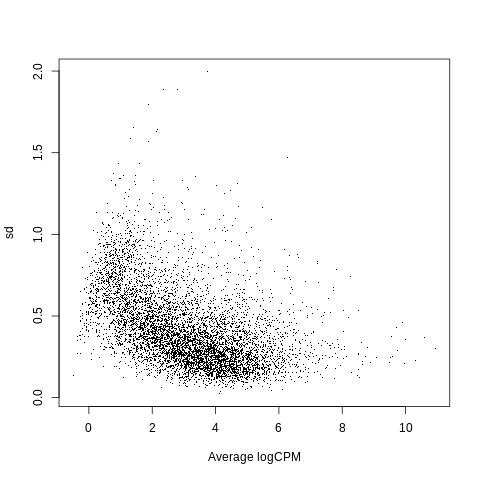

In [160]:
%R plot(mean.vec, sdvec, pch =".", ylab="sd", xlab="Average logCPM")

### Let us now make a dispersion plot

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



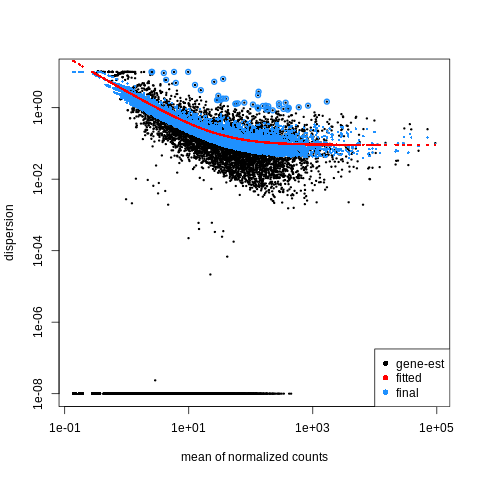

In [161]:
%%R  
    colnames(data)
    dds <- DESeqDataSetFromMatrix(countData = exprs(data), colData = pData(data), design = ~gender)
    dds <- DESeq(dds)
    plotDispEsts(dds)

### Next we would make a datafame from the dds object and export it to the pyhton 

In [162]:
%R -o dds
dds
print(dds)
%R ddsDF <- results(dds)
%R -o ddsDF
print(ddsDF)

class: DESeqDataSet 
dim: 52580 6 
metadata(1): version
assays(4): counts mu H cooks
rownames(52580): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(6): SRX014818and9 SRX014820and1 ... SRX014826and7
  SRX014828and9
colData names(4): sample.id num.tech.reps gender sizeFactor

log2 fold change (MLE): gender M vs F 
Wald test p-value: gender M vs F 
DataFrame with 52580 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat    pvalue
                <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSG00000000003  38.48617      -0.636080  0.633874 -1.0034813  0.315629
ENSG00000000005   0.00000             NA        NA         NA        NA
ENSG00000000419  16.53149      -0.045982  0.609659 -0.0754225  0.939879
ENSG00000000457  26.40137       0.171818  0.476003  0.3609608  0.718129
ENSG00000000460   1.95259       0.805282  1.602610  0.5024813  0.615329
...                   ...            

In [163]:
%R resultDds <- results(dds)
%R resultDds <- as.data.frame(resultDds)
%R -o resultDds
type(resultDds)

pandas.core.frame.DataFrame

In [164]:
resultDds.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003,38.486166,-0.636080,0.633874,-1.003481,0.315629,0.999979
ENSG00000000005,0.000000,NaN,NaN,NaN,NaN,NaN
ENSG00000000419,16.531493,-0.045982,0.609659,-0.075422,0.939879,0.999979
ENSG00000000457,26.401368,0.171818,0.476003,0.360961,0.718129,0.999979
ENSG00000000460,1.952594,0.805282,1.602610,0.502481,0.615329,0.999979


### Let us remove any duplicate rown just in case...

In [165]:
resultDds.drop_duplicates()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003,38.486166,-0.636080,0.633874,-1.003481,0.315629,0.999979
ENSG00000000005,0.000000,NaN,NaN,NaN,NaN,NaN
ENSG00000000419,16.531493,-0.045982,0.609659,-0.075422,0.939879,0.999979
ENSG00000000457,26.401368,0.171818,0.476003,0.360961,0.718129,0.999979
ENSG00000000460,1.952594,0.805282,1.602610,0.502481,0.615329,0.999979
...,...,...,...,...,...,...
ENSG00000254122,13.566756,-0.624627,0.620136,-1.007241,0.313819,0.999979
ENSG00000254128,1.354613,1.545178,1.897659,0.814255,0.415499,0.999979
ENSG00000254206,4.289691,1.362863,1.013185,1.345128,0.178584,0.999979
ENSG00000254221,2.276256,0.296591,1.427451,0.207777,0.835403,0.999979


### Let us select the rows with p value less than 0.05


In [166]:
(resultDds['pvalue'] <= 0.05) 

ENSG00000000003    False
ENSG00000000005    False
ENSG00000000419    False
ENSG00000000457    False
ENSG00000000460    False
                   ...  
LRG_94             False
LRG_96             False
LRG_97             False
LRG_98             False
LRG_99             False
Name: pvalue, Length: 52580, dtype: bool

### ... and those with positive log fold change


In [167]:
(resultDds['log2FoldChange'] >= 0)

ENSG00000000003    False
ENSG00000000005    False
ENSG00000000419    False
ENSG00000000457     True
ENSG00000000460     True
                   ...  
LRG_94             False
LRG_96             False
LRG_97             False
LRG_98             False
LRG_99             False
Name: log2FoldChange, Length: 52580, dtype: bool

### create a data frame with p value less than 0.05

In [168]:
resultDds05 = resultDds[resultDds['pvalue'] <= 0.05]
#(resultDds['log2FoldChange'] >= 0)

### select rows with p value less than 0.05 and log fold change more than 5

In [169]:
resultDds05[resultDds05['log2FoldChange'] >= 5]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000129824,35.864006,6.103900,3.085011,1.978567,0.047865,0.999979
ENSG00000138131,365.293870,5.045004,1.393825,3.619540,0.000295,0.388019


### select rows with p value less than 0.05 and log fold change in negative

In [170]:
geneID = resultDds05.index.tolist()
%R -i geneID 
%R gene.list <- as.character(geneID)
%R gene.list


'ENSG0000...,'ENSG0000...,'ENSG0000...,...,'ENSG0000...,'ENSG0000...,'ENSG0000...


In [171]:
%%R
    library(mygene)
    geneName <- getGenes(gene.list, fields='symbol')
    geneName

DataFrame with 279 rows and 5 columns
              query         _id X_version      symbol  notfound
        <character> <character> <integer> <character> <logical>
1   ENSG00000002834        3927         5       LASP1        NA
2   ENSG00000003249       79007         3      DBNDD1        NA
3   ENSG00000006210        6376        10      CX3CL1        NA
4   ENSG00000008323       55200         2     PLEKHG6        NA
5   ENSG00000008517        9235         5        IL32        NA
...             ...         ...       ...         ...       ...
275 ENSG00000215256       55449         1   DHRS4-AS1        NA
276 ENSG00000216588      147710         1      IGSF23        NA
277 ENSG00000242220      140290         4      TCP10L        NA
278 ENSG00000242574        3109         2     HLA-DMB        NA
279 ENSG00000244734        3043         6         HBB        NA


In [172]:
resultDds05[resultDds05['log2FoldChange'] <= 0]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000012124,11.487811,-1.723722,0.844196,-2.041850,0.041166,0.999979
ENSG00000013588,19.013981,-1.724493,0.866386,-1.990444,0.046542,0.999979
ENSG00000019549,20.535126,-1.797608,0.616859,-2.914131,0.003567,0.999979
ENSG00000024422,61.266958,-1.464572,0.517943,-2.827669,0.004689,0.999979
ENSG00000044574,600.087194,-1.059411,0.376333,-2.815092,0.004876,0.999979
...,...,...,...,...,...,...
ENSG00000198805,361.350697,-0.665147,0.339123,-1.961373,0.049836,0.999979
ENSG00000198899,3085.649983,-1.426550,0.613479,-2.325346,0.020053,0.999979
ENSG00000205038,8.542856,-2.005153,0.905479,-2.214465,0.026797,0.999979
ENSG00000215256,47.778264,-1.224522,0.518542,-2.361473,0.018203,0.999979


In [173]:
%R listGeneName <- geneName$symbol
%R -o listGeneName
print(listGeneName)

  [1] "LASP1"     "DBNDD1"    "CX3CL1"    "PLEKHG6"   "IL32"      "CD22"     
  [7] "GPRC5A"    "SNAI2"     "ALAS1"     "EHD2"      "HSPA5"     "H6PD"     
 [13] "PLEKHH1"   "TMCC3"     "CREB3L3"   "PFN2"      "CDH19"     "IRAG1"    
 [19] "MKRN2"     "MCAM"      "FDFT1"     "PTPRH"     "HSP90AA1"  "IRAK3"    
 [25] "EFNB1"     "RFFL"      "BAMBI"     "TREM2"     "EFNA2"     NA         
 [31] "CDHR5"     "OSM"       "MMP9"      "OXT"       "MYOM1"     "CHRDL1"   
 [37] "SRPX"      "F9"        "FLT1"      "NECAB2"    "CRISPLD2"  "MEFV"     
 [43] "TOX3"      "MAZ"       "RASL12"    "RETN"      "CLEC4M"    "PLA2G4C"  
 [49] "JAK3"      "CLDN15"    "PSMA2"     "OGN"       "ASPN"      "MINPP1"   
 [55] "ACTA2"     "TNFAIP1"   "CRYAB"     "APOA4"     "RNF141"    "POU2AF1"  
 [61] "MGP"       "IFNG"      "ENO2"      "LDHB"      "VNN2"      "ACVR2B"   
 [67] "IGFBP5"    "GNLY"      "MMP8"      "TCF21"     "FGF23"     "ZC2HC1C"  
 [73] "PPP1R3C"   "GNA13"     "TMPO"      "HS3ST2"    "SRGN"    

In [174]:
resultDds05['GeneName'] = listGeneName
resultDds05

<ipython-input-174-2c4f64a33c02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultDds05['GeneName'] = listGeneName


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName
ENSG00000002834,36.797449,0.963482,0.470134,2.049375,0.040425,0.999979,LASP1
ENSG00000003249,65.893079,2.988309,0.744210,4.015411,0.000059,0.124832,DBNDD1
ENSG00000006210,195.905358,0.962956,0.359309,2.680021,0.007362,0.999979,CX3CL1
ENSG00000008323,14.800023,1.280345,0.605227,2.115480,0.034389,0.999979,PLEKHG6
ENSG00000008517,273.532925,1.508017,0.666956,2.261044,0.023757,0.999979,IL32
...,...,...,...,...,...,...,...
ENSG00000215256,47.778264,-1.224522,0.518542,-2.361473,0.018203,0.999979,DHRS4-AS1
ENSG00000216588,23.506956,1.712557,0.676110,2.532956,0.011311,0.999979,IGSF23
ENSG00000242220,6.314970,2.081923,1.000790,2.080281,0.037500,0.999979,TCP10L
ENSG00000242574,31.791989,1.221171,0.536003,2.278291,0.022709,0.999979,HLA-DMB


In [175]:
listNegativeExpressedGenes= resultDds05[resultDds05['log2FoldChange'] <= 0]['GeneName']
listNegativeExpressedGenes

ENSG00000012124         CD22
ENSG00000013588       GPRC5A
ENSG00000019549        SNAI2
ENSG00000024422         EHD2
ENSG00000044574        HSPA5
                     ...    
ENSG00000198805          PNP
ENSG00000198899         ATP6
ENSG00000205038      PKHD1L1
ENSG00000215256    DHRS4-AS1
ENSG00000244734          HBB
Name: GeneName, Length: 173, dtype: object

### Max expression

In [176]:
resultDds05[resultDds05['log2FoldChange'] >= 5].max()

baseMean            365.294
log2FoldChange       6.1039
lfcSE               3.08501
stat                3.61954
pvalue            0.0478648
padj               0.999979
GeneName             RPS4Y1
dtype: object

In [177]:
resultDds05[resultDds05['log2FoldChange'] >= 5].dtypes

baseMean          float64
log2FoldChange    float64
lfcSE             float64
stat              float64
pvalue            float64
padj              float64
GeneName           object
dtype: object

### Make volcano plot

In [178]:
from bioinfokit import analys, visuz

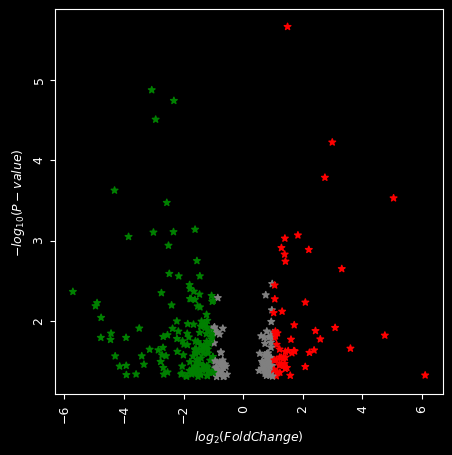

In [179]:
df = resultDds05
visuz.gene_exp.volcano(df=df, lfc='log2FoldChange', pv='pvalue', theme='dark', color=("red", "grey", "green"), markerdot='*', dotsize=25, show=True)

### Next we would use an R library called mygene to check convert geneid into the known gene names. Often time gene names are not available.

In [180]:
resultDds05[resultDds05['log2FoldChange'] >= 0]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName
ENSG00000002834,36.797449,0.963482,0.470134,2.049375,0.040425,0.999979,LASP1
ENSG00000003249,65.893079,2.988309,0.744210,4.015411,0.000059,0.124832,DBNDD1
ENSG00000006210,195.905358,0.962956,0.359309,2.680021,0.007362,0.999979,CX3CL1
ENSG00000008323,14.800023,1.280345,0.605227,2.115480,0.034389,0.999979,PLEKHG6
ENSG00000008517,273.532925,1.508017,0.666956,2.261044,0.023757,0.999979,IL32
...,...,...,...,...,...,...,...
ENSG00000214063,114.527296,0.779046,0.389764,1.998765,0.045634,0.999979,TSPAN4
ENSG00000214456,173.946616,1.060871,0.380995,2.784473,0.005361,0.999979,PLIN5
ENSG00000216588,23.506956,1.712557,0.676110,2.532956,0.011311,0.999979,IGSF23
ENSG00000242220,6.314970,2.081923,1.000790,2.080281,0.037500,0.999979,TCP10L


### Let us make the volcano plot to compare p value to the fold change

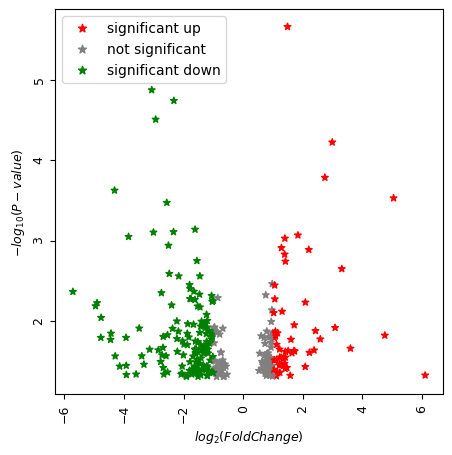

In [181]:
df = resultDds05
visuz.gene_exp.volcano(df=df, lfc='log2FoldChange', pv='pvalue',  color=("red", "grey", "green"), markerdot='*', plotlegend=True, dotsize=25, show=True)

### Now let us make the massachussettes plot

/home/srivastava/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/srivastava/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/srivastava/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:586: UserWarning: Warning: converting a masked element to nan.
  s = self.format % xp


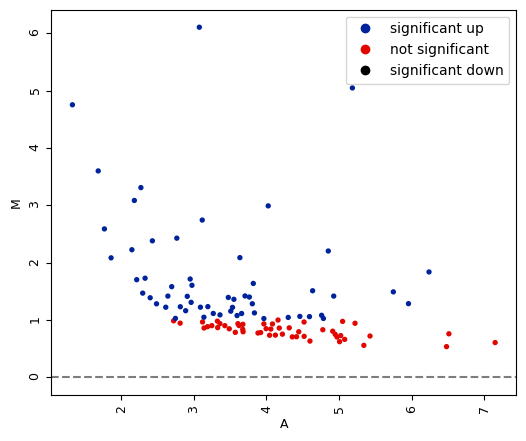

In [182]:
visuz.gene_exp.ma(df=df, lfc='log2FoldChange', ct_count='baseMean', st_count='stat', plotlegend=True, 
    color=('#00239CFF', 'grey', '#E10600FF'), show=True)

### Let us check the names of all the geneIds that we have queried

In [183]:
%R queryGeneName <- geneName$query
%R -o queryGeneName
queryGeneName
#print(queryGeneName)

'ENSG0000...,'ENSG0000...,'ENSG0000...,...,'ENSG0000...,'ENSG0000...,'ENSG0000...


In [184]:
%R exprsData <- exprs(data)
%R cpmMat <- cpm.mat
%R -o cpmMat
cpmMat

array([[3.7201211 , 3.70187149, 2.1923488 , 1.86838281, 3.36989703,
        3.02927173],
       [      -inf,       -inf,       -inf,       -inf,       -inf,
              -inf],
       [2.84465236, 1.8047515 , 2.12781027, 2.37920843, 2.60264188,
        1.81624909],
       ...,
       [      -inf,       -inf,       -inf,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf,       -inf,       -inf,
              -inf]])

In [185]:
%R exprsData <-  as.data.frame(exprsData)
%R -o exprsData
exprsData

,SRX014818and9,SRX014820and1,SRX014822and3,SRX014824and5,SRX014826and7,SRX014828and9
ENSG00000000003,60,60,16,9,56,37
ENSG00000000005,0,0,0,0,0,0
ENSG00000000419,25,9,15,15,26,11
ENSG00000000457,32,19,21,31,28,28
ENSG00000000460,1,3,0,5,1,1
...,...,...,...,...,...,...
LRG_94,0,0,0,0,0,0
LRG_96,0,0,0,0,0,0
LRG_97,0,0,0,0,0,0
LRG_98,0,0,0,0,0,0


### Let us check the 23rd entry

In [186]:
%R exprsData[rownames(exprsData) == queryGeneName[23],]


,SRX014818and9,SRX014820and1,SRX014822and3,SRX014824and5,SRX014826and7,SRX014828and9
ENSG00000080824,15,5,20,1,5,5


In [187]:
%%R
    dataFrameNew = 0
    x = length(queryGeneName )
    i = 1
    while (i <= x ){
    dataFrameNew = rbind(exprsData[rownames(exprsData) == queryGeneName[i],], dataFrameNew)
    i = i +1
    
    }


In [188]:
%R dataFrameNew = dataFrameNew[1:x,]
%R dataFrameNew


,SRX014818and9,SRX014820and1,SRX014822and3,SRX014824and5,SRX014826and7,SRX014828and9
ENSG00000244734,201.0,31.0,260.0,9.0,15.0,48.0
ENSG00000242574,17.0,22.0,16.0,63.0,44.0,27.0
ENSG00000242220,4.0,0.0,3.0,14.0,11.0,6.0
ENSG00000216588,13.0,11.0,8.0,13.0,25.0,81.0
ENSG00000215256,102.0,59.0,34.0,18.0,51.0,25.0
...,...,...,...,...,...,...
ENSG00000008517,64.0,104.0,245.0,652.0,99.0,422.0
ENSG00000008323,7.0,11.0,7.0,16.0,19.0,32.0
ENSG00000006210,90.0,133.0,162.0,229.0,381.0,218.0
ENSG00000003249,14.0,6.0,23.0,89.0,22.0,258.0


In [189]:
%R -o dataFrameNew
#type(dataFrameNew)

### Make a heatplot just because....

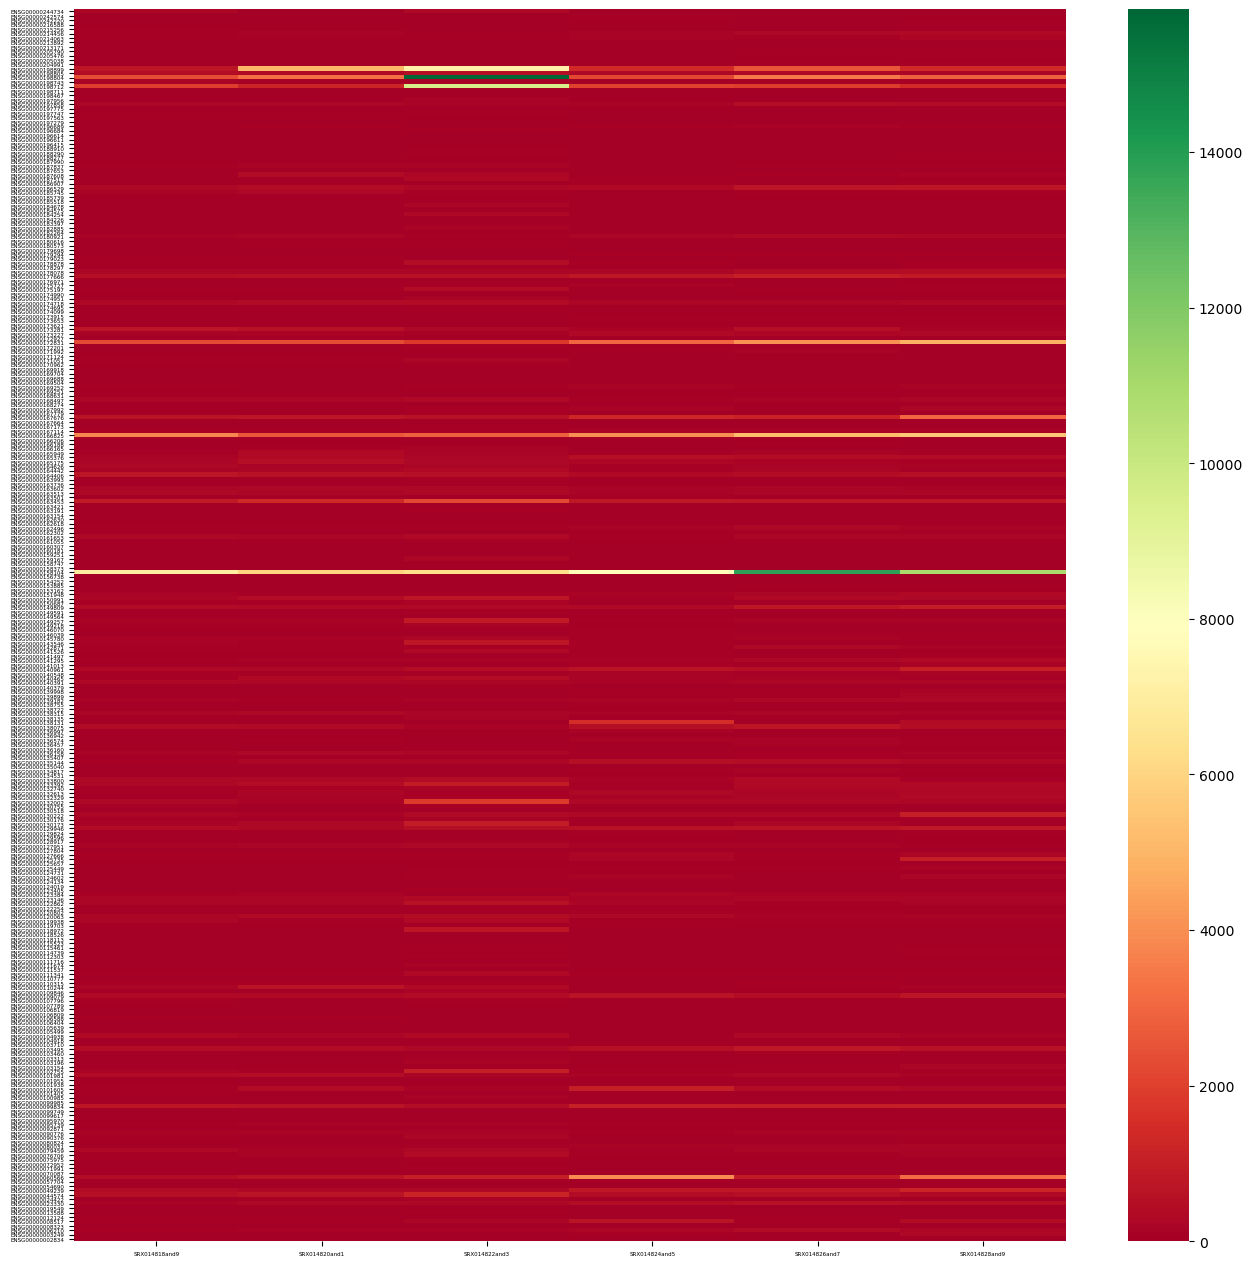

In [199]:
dfHm = dataFrameNew
visuz.gene_exp.hmap(df=dfHm, rowclus=False, colclus=False, cmap='RdYlGn', dim=(16, 16), tickfont=(4, 4), show=True)

### This looks unconclusive. So let us select only the genes with average count values greater than 120. 

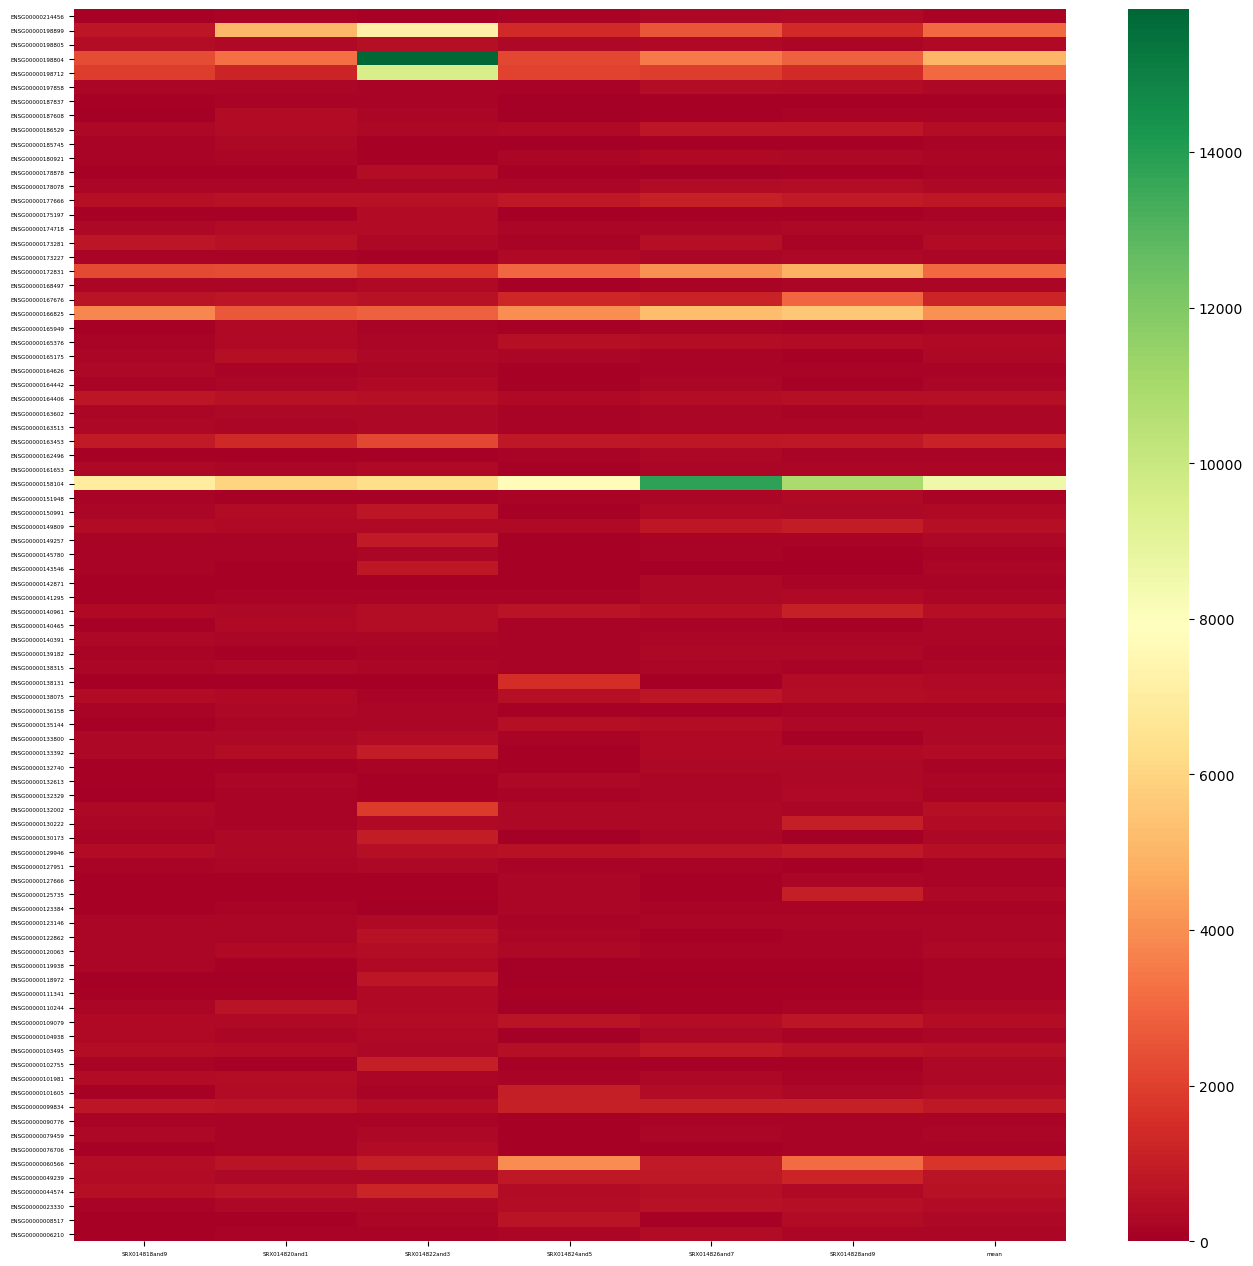

In [210]:
dfHm['mean'] = dfHm.mean(axis=1)
dfHm120 = dfHm[dfHm['mean'] >= 120]
visuz.gene_exp.hmap(df=dfHm120, rowclus=False, colclus=False, cmap='RdYlGn', dim=(16, 16), tickfont=(4, 4), show=True)

### Make a principal component analysis graph

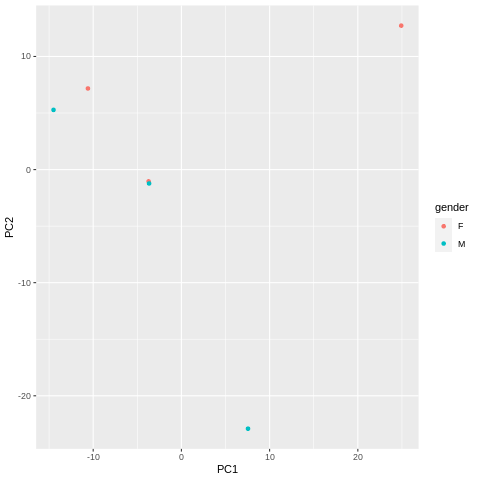

In [211]:
%%R 
    rld <- rlog(dds, blind=T)
    rld_mat <- assay(rld)
    pca <- prcomp(t(rld_mat))
    df <- cbind(pData(data), pca$x)
    ggplot(df) + geom_point(aes(x=PC1, y=PC2, color = gender))
